This week's riddler (https://fivethirtyeight.com/features/can-you-hunt-for-the-mysterious-numbers/) is about trying to fill in an 8x3 matrix, given the products of all the rows and columns. Every element of this matrix is an integer from 0 to 9.


|           |         |        |     |
|-----------|---------|--------|-----|
|           |         |        | 294 |
|           |         |        | 216 |
|           |         |        | 135 |
|           |         |        | 98  |
|           |         |        | 112 |
|           |         |        | 84  |
|           |         |        | 245 |
|           |         |        | 40  |
|-----------|---------|--------|-----|
| 8,890,560 | 156,800 | 55,566 |     |

The right hand column gives the product of each row, the bottom row gives the produce of each column.

There are 24 free parameters, with 10 values each, so the total search space is measured in moles. Since we are dealing with products of 8 variables, I don't see any way to use linear solvers to help here. In principle, we could throw in into a nonlinear solver, but I'm not optimistic that the minimum would be easy to find.

A smarter strategy (I suspect) is to start by solving the rows, which should be fairly simple, then do a search of the columns with the numbers we found. Let's see if this is feasible.

First, we'll check what the factors for the row products (and also the column products) look like. Apparently, python/numpy doesn't have a built in prime factors function, so instead let's just get every divisor < 10.

In [1]:
import numpy as np
import time

rowProds = np.array([294, 216, 135, 98, 112, 84, 245, 40])
colProds = np.array([8890560, 156800, 55566])

for n in rowProds:
    print('\n n={0}'.format(n))
    for i in range(2,10):
        if not (n%i):
            print(i)
            
for n in colProds:
    print('\n n={0}'.format(n))
    for i in range(2,10):
        if not (n%i):
            print(i)


 n=294
2
3
6
7

 n=216
2
3
4
6
8
9

 n=135
3
5
9

 n=98
2
7

 n=112
2
4
7
8

 n=84
2
3
4
6
7

 n=245
5
7

 n=40
2
4
5
8

 n=8890560
2
3
4
5
6
7
8
9

 n=156800
2
4
5
7
8

 n=55566
2
3
6
7
9


The immediate takeaway is that there usually isn't a lot of different ways to make a three digit number by multiplying 3 numbers. On the other handm the cloumns don't give us a lot of specificity. For the rows, since the search space is real small, let's just brute force the set of three numbers which can make up each of these rows. This has the nice(?) feature that it automatically returns every permutation of the factors, which will help for searching the rows.

In [2]:
def get3Factors(n):
    facts = []
    for i in range(1,10):
        for j in range(1,10):
            for k in range(1,10):
                if i*j*k==n:
                    facts.append([i, j, k])
    return np.vstack(facts)

totalSize = 1
rowFactors = []
allFactors = [] #a list of 2D arrays, each giving the avaiable permutations for a given row

tic = time.perf_counter()
for n in rowProds:
    print('\n n={0}'.format(n))
    f = get3Factors(n)
    uniqs = np.unique(f[:,0])
    rowFactors.append(uniqs)
    allFactors.append(f)
    print('Possible factors = \n {0}'.format(f))
    print('Unique factors = {0}'.format(uniqs))
    totalSize *= uniqs.size
    
print('\nTotal possible combinations for columns = {0}'.format(totalSize))
toc = time.perf_counter()
print(f"\nCombinations found in {(toc - tic)*1000:0.2f} ms")


 n=294
Possible factors = 
 [[6 7 7]
 [7 6 7]
 [7 7 6]]
Unique factors = [6 7]

 n=216
Possible factors = 
 [[3 8 9]
 [3 9 8]
 [4 6 9]
 [4 9 6]
 [6 4 9]
 [6 6 6]
 [6 9 4]
 [8 3 9]
 [8 9 3]
 [9 3 8]
 [9 4 6]
 [9 6 4]
 [9 8 3]]
Unique factors = [3 4 6 8 9]

 n=135
Possible factors = 
 [[3 5 9]
 [3 9 5]
 [5 3 9]
 [5 9 3]
 [9 3 5]
 [9 5 3]]
Unique factors = [3 5 9]

 n=98
Possible factors = 
 [[2 7 7]
 [7 2 7]
 [7 7 2]]
Unique factors = [2 7]

 n=112
Possible factors = 
 [[2 7 8]
 [2 8 7]
 [4 4 7]
 [4 7 4]
 [7 2 8]
 [7 4 4]
 [7 8 2]
 [8 2 7]
 [8 7 2]]
Unique factors = [2 4 7 8]

 n=84
Possible factors = 
 [[2 6 7]
 [2 7 6]
 [3 4 7]
 [3 7 4]
 [4 3 7]
 [4 7 3]
 [6 2 7]
 [6 7 2]
 [7 2 6]
 [7 3 4]
 [7 4 3]
 [7 6 2]]
Unique factors = [2 3 4 6 7]

 n=245
Possible factors = 
 [[5 7 7]
 [7 5 7]
 [7 7 5]]
Unique factors = [5 7]

 n=40
Possible factors = 
 [[1 5 8]
 [1 8 5]
 [2 4 5]
 [2 5 4]
 [4 2 5]
 [4 5 2]
 [5 1 8]
 [5 2 4]
 [5 4 2]
 [5 8 1]
 [8 1 5]
 [8 5 1]]
Unique factors = [1 2 4 5 8]

Total

So it looks like it is well within reason to simply do a search, since there's only 12,000 ways of doing it (and we can likely exclude a lot of them quickly). Since we're doing an exhaustive search, we'll get all 3 columns at once, although it won't know anything about reuse. We'll worry about getting the correct columns later

I feel like recursion is the way to go with this one.

In [3]:

#recursively depth first search the whole tree of possible factors for the columns.
#if at any point there isn't a matching product, we can abandon this trip down
def getColProducts(rowFactors, colProds, prod, chain, depth, solutions=[]):
    for n in rowFactors[depth]:
        if depth==0:
            for p in colProds:
                if (prod*n == p):
                    print(f'Column found for product {p}: {np.flip(np.append(chain, n))}')
                    try: #if we don't have any slutions yet, make some
                        solutions = np.vstack((solutions, np.flip(np.append(chain, n))))
                    except:
                        solutions = np.flip(np.append(chain, n))
        else:
            cont = False #so that we can break if there are no solutions coming
            for p in colProds:
                if (p%(prod*n) == 0):
                    cont = True
            if cont:  
                solutions = getColProducts(rowFactors, colProds, prod*n, np.append(chain, n), depth-1, solutions)
               # if s.size > 0:
                #    solutions = np.vstack((solutions, s))
    return solutions
                
tic = time.perf_counter()
colSols=getColProducts(rowFactors, colProds, 1, np.empty(0), 7)
toc = time.perf_counter()
print(f"\nProducts found in {(toc - tic)*1000:0.2f} ms")


Column found for product 156800: [7. 8. 5. 7. 8. 2. 5. 1.]
Column found for product 156800: [7. 8. 5. 7. 4. 4. 5. 1.]
Column found for product 156800: [7. 4. 5. 7. 8. 4. 5. 1.]
Column found for product 156800: [7. 8. 5. 2. 8. 7. 5. 1.]
Column found for product 55566: [7. 9. 3. 7. 2. 3. 7. 1.]
Column found for product 55566: [7. 3. 9. 7. 2. 3. 7. 1.]
Column found for product 55566: [7. 9. 3. 2. 7. 3. 7. 1.]
Column found for product 55566: [7. 3. 9. 2. 7. 3. 7. 1.]
Column found for product 55566: [6. 3. 3. 7. 7. 3. 7. 1.]
Column found for product 156800: [7. 8. 5. 7. 4. 2. 5. 2.]
Column found for product 156800: [7. 4. 5. 7. 8. 2. 5. 2.]
Column found for product 156800: [7. 8. 5. 7. 2. 4. 5. 2.]
Column found for product 156800: [7. 4. 5. 7. 4. 4. 5. 2.]
Column found for product 156800: [7. 8. 5. 2. 7. 4. 5. 2.]
Column found for product 156800: [7. 8. 5. 2. 4. 7. 5. 2.]
Column found for product 156800: [7. 4. 5. 2. 8. 7. 5. 2.]
Column found for product 156800: [7. 8. 5. 7. 2. 2. 5. 4.]
Co

Alright. That got us pretty close. There's even a unique solution for the first column, so we could probably just solve the rest using that list and a bit of deduction. This will also have a bunch of solutions that make no sense, since we are just looking at every possible row factor. Now to do it a bit smarter.


In [4]:
#recursively depth first search the whole tree, but this time look at the possible column permutations, and match based on rows
def solveColumns(allFactors, colPr, prod, depth, chain=[], solutions=[]):
    f = allFactors[depth] #the 2D array of factors for a given row
    for row in f:
        if depth==0:
        #    print(f'prod = {prod}, row={row}, prod*row={prod*row}')
            if np.all(prod*row == colPr):
                s = np.flip(np.vstack((chain, row)), axis=0)
             #   print(f'Solution found:\n {s}\n')
                try: #if we don't have any solutions yet, make some
                    solutions.append(s)
                except:
                    solutions = [s]
        else:
            if np.all(colPr%(prod*row) == 0): #bin all the bad leads
                try:
                    solutions = solveColumns(allFactors, colPr, prod*row, depth-1, chain=np.vstack((chain, row)), solutions=solutions)
                except:
                    solutions = solveColumns(allFactors, colPr, prod*row, depth-1, chain=row, solutions=solutions)
    return solutions
                
tic = time.perf_counter()
sols=solveColumns(allFactors, colProds, np.array([1, 1, 1]), 7, solutions=[])
toc = time.perf_counter()
print(f"\nSolution found in {(toc - tic)*1000:0.2f} ms\n")

print(f"Solution = \n{sols[0]}")
print(f"Product of rows = {np.prod(sols[0], axis=1)}, expected {rowProds}")
print(f"Product of cols = {np.prod(sols[0], axis=0)}, expected {colProds}")


Solution found in 30.34 ms

Solution = 
[[7 7 6]
 [9 8 3]
 [9 5 3]
 [7 2 7]
 [8 2 7]
 [7 4 3]
 [5 7 7]
 [8 5 1]]
Product of rows = [294 216 135  98 112  84 245  40], expected [294 216 135  98 112  84 245  40]
Product of cols = [8890560  156800   55566], expected [8890560  156800   55566]


Happy days! Solution found, and pretty quickly too.

There is a unique solution for this set of numbers, but I wonder if that's an unusual feature or not. Let's automate the whole process a bit more, and then try throwing in some randomly generated sets of products, too see how unique these tend to be

In [5]:
def getRowFactors(rowPr, printout=True):
    totalSize = 1
    rowFactors = []
    allFactors = [] #a list of 2D arrays, each giving the avaiable permutations for a given row

    tic = time.perf_counter()
    for n in rowPr:
        f = get3Factors(n)
        uniqs = np.unique(f[:,0])
        rowFactors.append(uniqs)
        allFactors.append(f)
        totalSize *= uniqs.size

    if printout:
        print('\nTotal possible combinations for columns = {0}'.format(totalSize))
        toc = time.perf_counter()
        print(f"\nRow combinations found in {(toc - tic)*1000:0.2f} ms\n\n")
    return allFactors

def solveProds(rp, cp, printout=True):
    allFactors = getRowFactors(rp, printout)
    tic = time.perf_counter()
    sols=solveColumns(allFactors, cp, np.array([1, 1, 1]), 7, solutions=[])
    toc = time.perf_counter()
    
    if printout:
        print(f"Found {len(sols)} solution(s)")
        print(f"\nSolutions found in {(toc - tic)*1000:0.2f} ms\n")

        n = 0
        for s in sols:
            print(f"Solution[{n}] = \n{s}")
            print(f"Product of rows = {np.prod(s, axis=1)}, expected {rp}")
            print(f"Product of cols = {np.prod(s, axis=0)}, expected {cp}\n")
            n += 1
            if n>50:
                break
        print("---------------")
    return sols

In [6]:
def solveRandom(printout=True):
    target = np.random.randint(1, high=10, size=(8,3))
    if printout:
        print(f"Target matrix = \n{target}")
    return solveProds(np.prod(target, axis=1), np.prod(target, axis=0), printout=printout)

ranSol = solveRandom(printout=True)

Target matrix = 
[[2 4 5]
 [2 3 7]
 [8 4 6]
 [8 7 6]
 [5 8 1]
 [6 3 5]
 [7 5 9]
 [8 8 8]]

Total possible combinations for columns = 22500

Row combinations found in 2.12 ms


Found 262 solution(s)

Solutions found in 77.77 ms

Solution[0] = 
[[8 1 5]
 [7 6 1]
 [8 6 4]
 [6 8 7]
 [2 4 5]
 [2 5 9]
 [5 7 9]
 [8 8 8]]
Product of rows = [ 40  42 192 336  40  90 315 512], expected [ 40  42 192 336  40  90 315 512]
Product of cols = [430080 322560 453600], expected [430080 322560 453600]

Solution[1] = 
[[8 1 5]
 [7 6 1]
 [6 8 4]
 [8 6 7]
 [2 4 5]
 [2 5 9]
 [5 7 9]
 [8 8 8]]
Product of rows = [ 40  42 192 336  40  90 315 512], expected [ 40  42 192 336  40  90 315 512]
Product of cols = [430080 322560 453600], expected [430080 322560 453600]

Solution[2] = 
[[4 2 5]
 [7 6 1]
 [8 6 4]
 [6 8 7]
 [4 2 5]
 [2 5 9]
 [5 7 9]
 [8 8 8]]
Product of rows = [ 40  42 192 336  40  90 315 512], expected [ 40  42 192 336  40  90 315 512]
Product of cols = [430080 322560 453600], expected [430080 322560 4536

Huh. In the majority of cases there are hundreds to thousands of valid solutions for a given set of row and product columns. Let's build a quick histogram to see what the distribution looks like. Since this sometimes takes ages, we'll set a time limit

In [7]:
import matplotlib.pyplot as plt

maxN = 10000
maxTime = 3600 #3600
startTime = time.perf_counter()
nSols = np.zeros(maxN)

n = 0
while (n<maxN and (time.perf_counter() - startTime)<maxTime):
    nSols[n] = len(solveRandom(printout=False))
    n += 1
    
nSols = nSols[0:n-1]



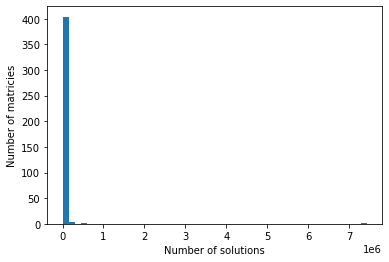

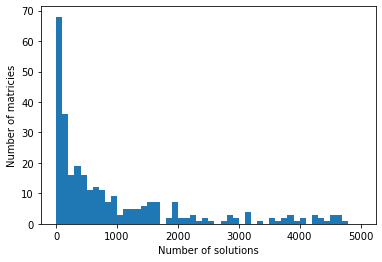

In [8]:
import matplotlib.pyplot as plt

plt.hist(nSols, bins=50)
plt.xlabel('Number of solutions')
plt.ylabel('Number of matricies')
plt.show()

plt.hist(nSols, bins=50, range=(0,5000))
plt.xlabel('Number of solutions')
plt.ylabel('Number of matricies')
plt.show()

So it seems like the majority have a fairly small number of possible solutions, but the tail on the distribution goes very large indeed